In [0]:
# Check GPU enable on Colab
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [0]:
!curl https://course.fast.ai/setup/colab | bash

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   321  100   321    0     0   4652      0 --:--:-- --:--:-- --:--:--  4652
Updating fastai...
Done.


# Pretrained GAN

In [0]:
import fastai
from fastai.vision import *
from fastai.callbacks import *
from fastai.vision.gan import *

## Dataset

In [0]:
path = untar_data(URLs.PETS)

In [0]:
path_hr = path/"images"
path_lr = path/'crappy'

In [0]:
from PIL import Image, ImageDraw, ImageFont

class crappifier(object):
    def __init__(self, path_lr, path_hr):
        self.path_lr = path_lr
        self.path_hr = path_hr              
        
    def __call__(self, fn, i):       
        dest = self.path_lr/fn.relative_to(self.path_hr)    
        dest.parent.mkdir(parents=True, exist_ok=True)
        img = PIL.Image.open(fn)
        targ_sz = resize_to(img, 96, use_min=True)
        img = img.resize(targ_sz, resample=PIL.Image.BILINEAR).convert('RGB')
        w,h = img.size
        q = random.randint(10,70)
        ImageDraw.Draw(img).text((random.randint(0,w//2),random.randint(0,h//2)), str(q), fill=(255,255,255))
        img.save(dest, quality=q)

In [0]:
il = ImageList.from_folder(path_hr)
parallel(crappifier(path_lr, path_hr), il.items)

In [0]:
bs, size = 32, 128

## Pretrain generator

In [0]:
arch = models.resnet34

In [0]:
src = ImageImageList.from_folder(path_lr).split_by_rand_pct(0.1, seed=42)

In [0]:
def get_data(bs,size):
    data = (src.label_from_func(lambda x: path_hr/x.name)
           .transform(get_transforms(max_zoom=2.), size=size, tfm_y=True)
           .databunch(bs=bs).normalize(imagenet_stats, do_y=True))

    data.c = 3
    return data

In [0]:
data_gen = get_data(bs, size)

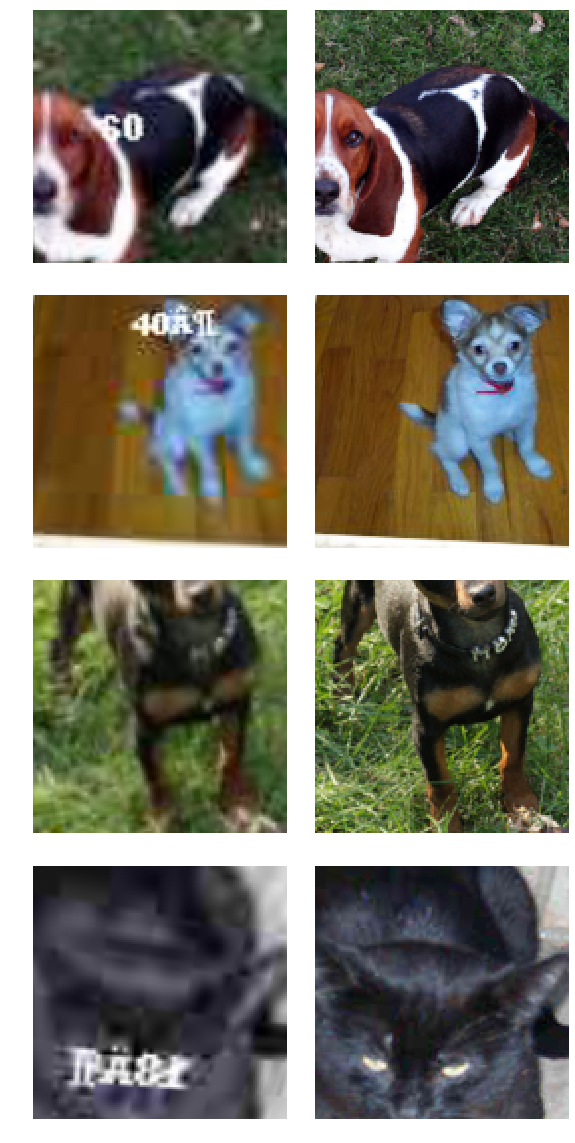

In [0]:
data_gen.show_batch(4)

In [0]:
wd = 1e-3

In [0]:
y_range = (-3.,3.)

In [0]:
loss_gen = MSELossFlat()

In [0]:
def create_gen_learner():
    return unet_learner(data_gen, arch, wd=wd, blur=True, norm_type=NormType.Weight,
                         self_attention=True, y_range=y_range, loss_func=loss_gen)

In [0]:
learn_gen = create_gen_learner()

In [0]:
learn_gen.fit_one_cycle(2, pct_start=0.8)

In [0]:
learn_gen.unfreeze()

In [0]:
learn_gen.fit_one_cycle(3, slice(1e-6,1e-3))

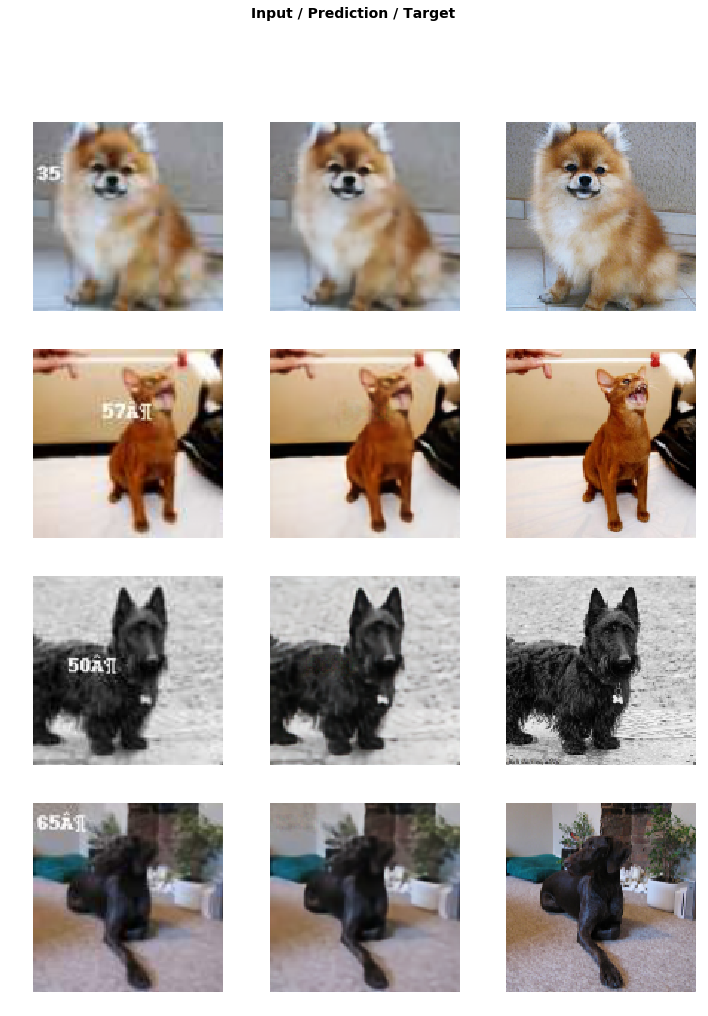

In [0]:
learn_gen.show_results(rows=4)

In [0]:
learn_gen.save('gen-stage-1')

### Save generated images

In [0]:
name_gen = "image_gen"
path_gen = path/name_gen

In [0]:
path_gen.mkdir(exist_ok=True)

In [0]:
def save_preds(dl):
    i=0
    names = dl.dataset.items
    
    for b in dl:
        preds = learn_gen.pred_batch(batch=b, reconstruct=True)
        for o in preds:
            o.save(path_gen/names[i].name)
            i += 1

In [0]:
save_preds(data_gen.fix_dl)

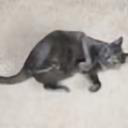

In [0]:
PIL.Image.open(path_gen.ls()[0])

## Train critic

In [0]:
learn_gen=None
gc.collect()

38440

In [0]:
def get_crit_data(classes, bs, size):
    src = ImageList.from_folder(path, include=classes).split_by_rand_pct(0.1, seed=42)
    ll = src.label_from_folder(classes=classes)
    data = (ll.transform(get_transforms(max_zoom=2.), size=size)
           .databunch(bs=bs).normalize(imagenet_stats))
    data.c = 3
    return data

In [0]:
data_crit = get_crit_data([name_gen, "images"], bs=bs, size=size)

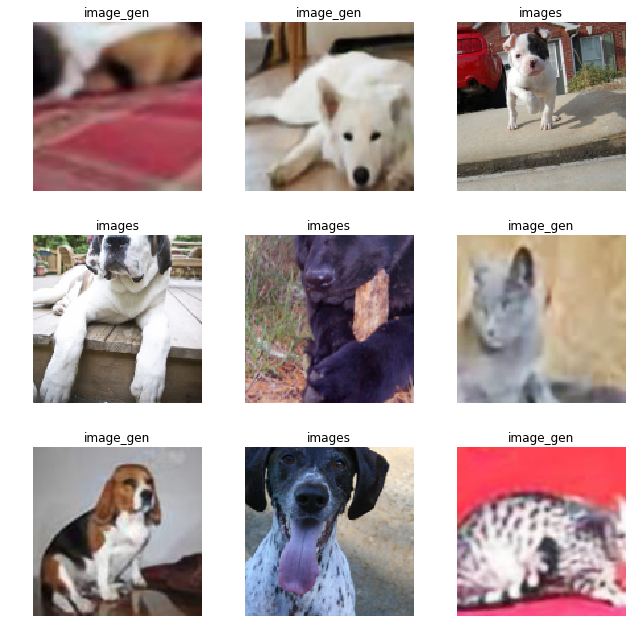

In [0]:
data_crit.show_batch(rows=3, ds_type=DatasetType.Train, imgsize=3)

In [0]:
loss_critic = AdaptiveLoss(nn.BCEWithLogitsLoss())

In [0]:
def create_critic_learner(data, metrics):
    return Learner(data, gan_critic(), metrics=metrics, loss_func=loss_critic, wd=wd)

In [0]:
learn_critic = create_critic_learner(data_crit, accuracy_thresh_expand)

In [0]:
learn_critic.fit_one_cycle(6, 1e-3)

In [0]:
learn_critic.save("critic-stage-1")

## GAN

In [0]:
learn_crit=None
learn_gen=None
gc.collect()

15795

In [0]:
data_crit = get_crit_data(["crappy", "images"], bs=bs, size=size)

In [0]:
learn_crit = create_critic_learner(data_crit, metrics=None).load("critic-stage-1")

In [0]:
learn_gen = create_gen_learner().load("gen-stage-1")

In [0]:
switcher = partial(AdaptiveGANSwitcher, critic_thresh=0.65)
learn = GANLearner.from_learners(learn_gen, learn_crit, weights_gen=(1.,50.), show_img=False, switcher=switcher,
                                 opt_func=partial(optim.Adam, betas=(0.,0.99)), wd=wd)
learn.callback_fns.append(partial(GANDiscriminativeLR, mult_lr=5.))

In [0]:
lr = 1e-4

In [0]:
learn.fit(40,lr)

In [0]:
learn.save("gan-critic-stage-1")

In [0]:
learn.load("gen-critic-stage-1")

AttributeError: ignored

In [0]:
learn.data=get_data(16,192)

In [0]:
learn.fit(10,lr/2)

KeyboardInterrupt: ignored

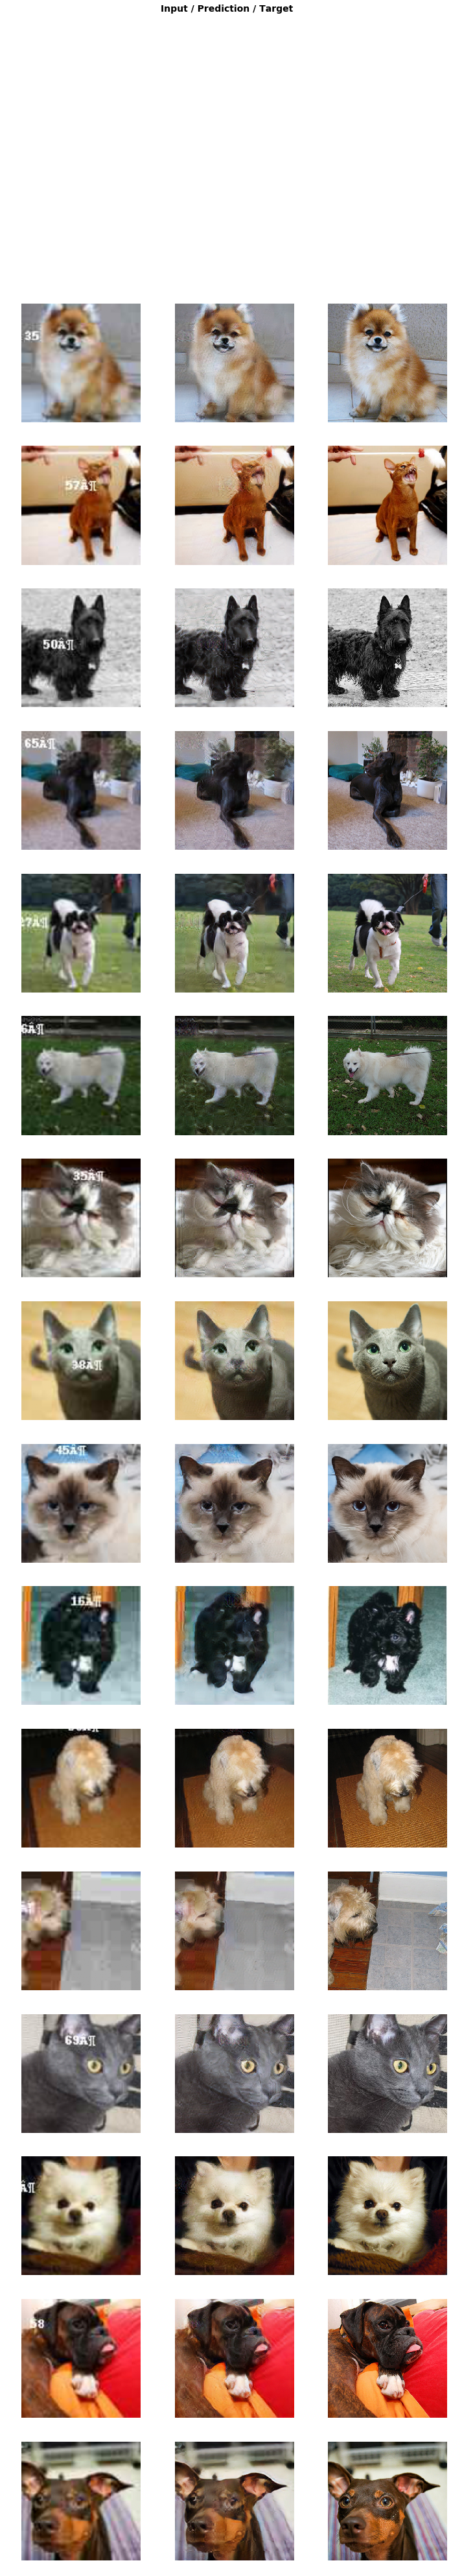

In [0]:
learn.show_results(rows=16)

In [0]:
learn.save('gan-critic-stage-2')